In [1]:
import pickle
import matplotlib.colors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
""" 
This is a script intended to demonstrate the comparison of a directional wave buoy observation to a WW3 model 
spectrum. The buoy data (bulk params and spectra) and example WW3 spectrum must be downloaded from the Google Drive. 
The WW3 spectra is 36 frequency bins (log distributed) and 36 directional bins, and is the energy density spectrum 
in frequency-direction space (units of m2/Hz/degree).
    
The directional wave buoy provides the energy density (0th moment) and first four Fourier coefficients of the
 directional spectrum. Code for deriving these quanities from the 2D frequency-direction model spectrum is below.
 
 Note: this is a low-resolution, non-assimilated WW3 model run - low skill when compared to the observation.
 Note: example figures expected to be rendered are also in the Drive
 
 email isabel.houghton@sofarocean.com for questions / issues.
 """
# if you want to use the reconstruction methods - run $ pip3 install --upgrade roguewave
# comment out the reconstruction code if not
from roguewave.wavespectra.estimators.estimate import estimate_directional_distribution

# TODO:
# download data files from shared NHCI Google Drive: https://drive.google.com/drive/folders/1WG2dwQBaW3MqNwWP3ysYgN6vxFSqZG9f

# TODO: change file paths to point to your local files
local_directory = "/vortexfs1/home/csherwood/proj/NOPP/data/"
wave_file_local = f'{local_directory}waves_SPOT-30065D.csv'
spectra_file_local = f'{local_directory}spectra_SPOT-30065D.npz'
model_spectrum_file_local = f'{local_directory}example_model_spectrum.pkl'
print(wave_file_local)

def integrate_in_frequency(data_field, frequencies):
    return np.trapz(data_field, frequencies, axis=0).squeeze()


def integrate_in_direction(data_field, directional_bin_width):
    return np.sum(data_field * directional_bin_width, axis=1).squeeze()


# open buoy data
with open(wave_file_local) as handle:
    wave_data = pd.read_csv(handle)
spectra_data = np.load(spectra_file_local)

time_ind = 36  # choose an hour to look at (36th hour aligns with example model spectrum)

# access the data from the buoy files
observation_latitude = wave_data["latitude"].iloc[time_ind]
observation_longitude = wave_data["longitude"].iloc[time_ind]

observation_hs = wave_data["significant_waveheight"].iloc[time_ind]
observation_tm = wave_data["mean_period"].iloc[time_ind]
observation_dm = wave_data["mean_direction"].iloc[time_ind]

spotter_energy_density = spectra_data["variance_density"][time_ind, :]
spotter_a1 = spectra_data["a1"][time_ind, :]
spotter_b1 = spectra_data["b1"][time_ind, :]
spotter_a2 = spectra_data["a2"][time_ind, :]
spotter_b2 = spectra_data["b2"][time_ind, :]

spotter_frequency = spectra_data["frequency"]
times = spectra_data["time"]

# access the data from the WW3 example spectrum file (a pickled dictionary)
with open(model_spectrum_file_local, "rb") as handle:
    model_data_dictionary = pickle.load(handle)

spectrum = model_data_dictionary["frequencyDirectionSpectrum"]
frequencies = model_data_dictionary["frequencies"]
directions = model_data_dictionary["directions"]
direction_radians = model_data_dictionary["direction_radians"]
directional_bin_width = model_data_dictionary["directional_bin_width"]
print(directional_bin_width)
# The wave spectra is 36 frequencies (dim 0) x 36 degrees (dim 1)
energy_density_spectrum = integrate_in_direction(spectrum, directional_bin_width)

# each directional coefficient (a1, b1..) is a Fourier coefficient of the 2D WW3 spectrum,
# normalized by the 1D (directionally-integrated) energy density spectrum
a1 = integrate_in_direction(spectrum * np.cos(direction_radians),
                            directional_bin_width=directional_bin_width) / energy_density_spectrum

a2 = integrate_in_direction(spectrum * np.cos(2 * direction_radians),
                            directional_bin_width=directional_bin_width) / energy_density_spectrum

b1 = integrate_in_direction(spectrum * np.sin(direction_radians),
                            directional_bin_width=directional_bin_width) / energy_density_spectrum

b2 = integrate_in_direction(spectrum * np.sin(2 * direction_radians),
                            directional_bin_width=directional_bin_width) / energy_density_spectrum

# this uses the reconstruction methods to illustrate issues with reconstruction
# (comment out if not using the pip package roguewave)
regenerated_spectrum = (
        estimate_directional_distribution(
            a1,
            b1,
            a2,
            b2,
            directions,
            method="mem2",
        ).T
        * energy_density_spectrum
)

spotter_spectrum_mem2 = (
        estimate_directional_distribution(
            spotter_a1,
            spotter_b1,
            spotter_a2,
            spotter_b2,
            direction=directions,
            method="mem2",
        ).T
        * spotter_energy_density
)



# some quick calculations of bulk statistics
m0 = np.trapz(energy_density_spectrum, frequencies)
m1 = np.trapz(energy_density_spectrum * frequencies, frequencies)

integrated_a1 = np.trapz(a1 * energy_density_spectrum, frequencies) / m0
integrated_b1 = np.trapz(b1 * energy_density_spectrum, frequencies) / m0

model_hs = 4 * np.sqrt(m0)
model_dm = np.arctan2(integrated_b1, integrated_a1) * 180 / np.pi
model_tm = m0 / m1

print(f"H_s model: {model_hs:.2f} m, obs: {observation_hs:.2f} m")
print(f"T_m model: {model_tm:.2f} s, obs: {observation_tm:.2f} s")
print(f"D_m model: {model_dm:.2f} deg, obs: {observation_dm:.2f} deg")

/vortexfs1/home/csherwood/proj/NOPP/data/waves_SPOT-30065D.csv
10.0
H_s model: 4.16 m, obs: 4.73 m
T_m model: 7.17 s, obs: 8.14 s
D_m model: -116.96 deg, obs: 46.27 deg


In [5]:
print(np.shape(spectrum))
np.shape(direction_radians)

(36, 36)


(36,)

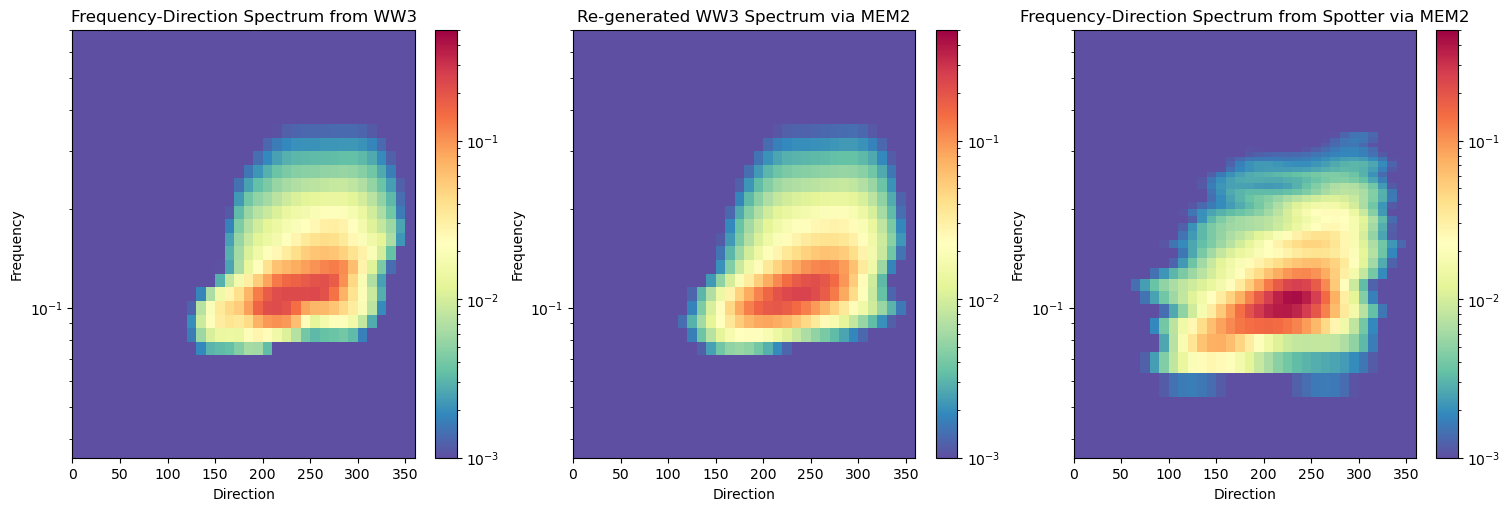

In [4]:
# plot the different 2D spectra (WW3 and reconstructed)
fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
axs = axs.flatten()
ax = axs[0]
pcm = ax.pcolormesh(directions, frequencies, spectrum, cmap="Spectral_r",
                    norm=matplotlib.colors.LogNorm(vmin=1e-3, vmax=.5))
ax.set_title('Frequency-Direction Spectrum from WW3')
ax.set_yscale("log")
plt.colorbar(pcm, ax=ax)

ax = axs[1]
pcm = ax.pcolormesh(directions, frequencies, regenerated_spectrum.T, cmap="Spectral_r",
                    norm=matplotlib.colors.LogNorm(vmin=1e-3, vmax=.5))

ax.set_title('Re-generated WW3 Spectrum via MEM2')
ax.set_yscale("log")
plt.colorbar(pcm, ax=ax)

ax = axs[2]
pcm = ax.pcolormesh(directions, spotter_frequency, spotter_spectrum_mem2.T, cmap="Spectral_r",
                    norm=matplotlib.colors.LogNorm(vmin=1e-3, vmax=.5))
ax.set_title('Frequency-Direction Spectrum from Spotter via MEM2')
ax.set_yscale("log")
plt.colorbar(pcm, ax=ax)

for ax in axs.flatten():
    ax.set(xlabel="Direction", ylabel="Frequency")
    ax.set_ylim(0.035, .7)

plt.savefig('frequency_direction_spectrum_comparison.png', dpi=250)
plt.show()


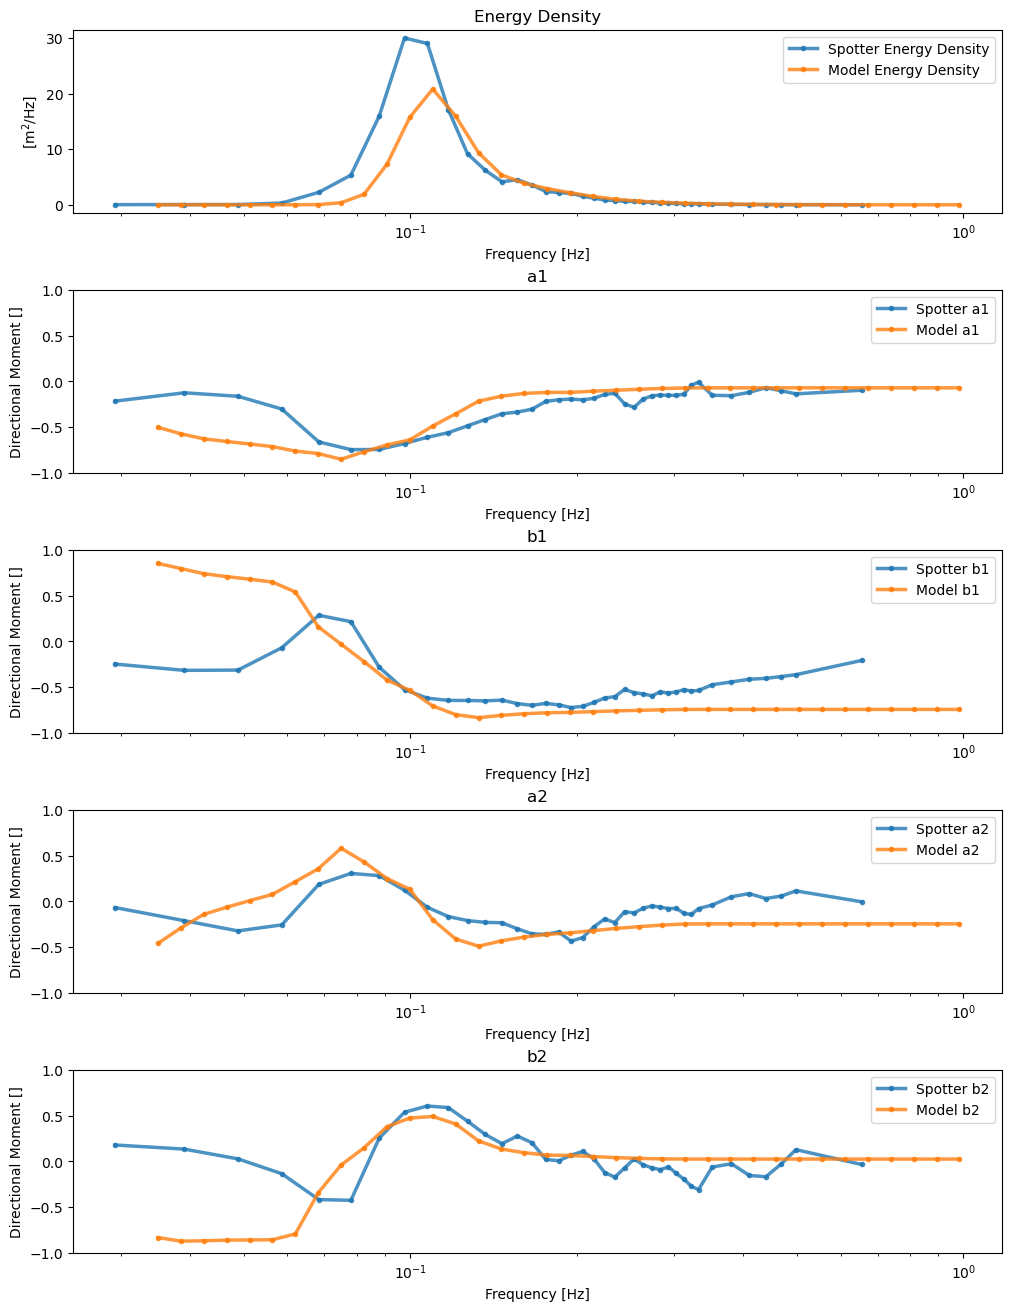

In [5]:
fig, axs = plt.subplots(5, 1, figsize=(10, 13), constrained_layout=True)
for name, spotter_val, model_val, ax in zip(["Energy Density", "a1", "b1", "a2", "b2"],
                                            [spotter_energy_density, spotter_a1, spotter_b1, spotter_a2, spotter_b2],
                                            [energy_density_spectrum, a1, b1, a2, b2],
                                            axs.flatten()):
    ax.plot(spotter_frequency, spotter_val, marker='.', label=f"Spotter {name}", alpha=0.8, lw=2.5)
    ax.plot(frequencies, model_val, marker='.', label=f"Model {name}", alpha=0.8, lw=2.5)
    ax.set_xscale('log')
    ax.set(title=name)
    ax.legend()
    if name != "Energy Density":
        ax.set_ylim(-1, 1)
        ax.set(xlabel='Frequency [Hz]', ylabel='Directional Moment []')

    else:
        # ax.set_yscale('log')
        ax.set(xlabel='Frequency [Hz]', ylabel='[m$^2$/Hz]')

plt.savefig('buoy_to_model_comparison.png',dpi=250)
plt.show()



In [11]:
directions.shape
d = np.linspace(5,355,36)
directions

array([  5.      ,  15.      ,  25.000002,  35.      ,  45.      ,
        55.      ,  65.      ,  75.      ,  85.00001 ,  95.00001 ,
       105.      , 115.      , 125.      , 135.00002 , 145.00002 ,
       155.00002 , 165.      , 175.      , 185.      , 195.      ,
       205.00002 , 215.      , 225.00002 , 235.      , 245.00002 ,
       255.      , 265.      , 275.      , 285.00003 , 295.      ,
       305.00003 , 315.      , 325.      , 335.      , 345.      ,
       355.      ], dtype=float32)

In [12]:
np.shape(spectrum)

(36, 36)